# Step 1 - Configure Environment

Hardware and Software Specification of the Computer

Hardware
* MacBookAir(Retina,13-inch,2018) 
* Processor:1.6GHzIntelCorei5
* Memory:8GB2133MHzLPDDR3
* Environment: GPU (in order to speed up my codes)

Software
* Google Colab with GPU Environment


In [1]:
from google.colab import drive
#connect to google colab
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks/ass2")
#this path is that you store the cifar-100 data including train and test and also store the train model

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import _LRScheduler
import pickle
import time

In [4]:
#check whether it is GPU environment, if GPU then print "cuda:0", else "cpu"

#****you must run codes after changing running type to GPU****
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Step 2 - Load data

In [5]:
# load train dataset (50000)
with open('train', 'rb') as fo:
  train = pickle.load(fo, encoding='bytes')
train_fine_labels = np.array(train[b'fine_labels'])
train_coarse_labels = np.array(train[b'coarse_labels'])
train_data = train[b'data']
print(train_fine_labels.shape)
print(train_coarse_labels.shape)
print(train_data.shape)

(50000,)
(50000,)
(50000, 3072)


In [6]:
# load test dataset (50000)
with open('test', 'rb') as fo:
  test = pickle.load(fo, encoding='bytes')
test_fine_labels = np.array(test[b'fine_labels'])
test_coarse_labels = np.array(test[b'coarse_labels'])
test_data = test[b'data']
print(test_fine_labels.shape)
print(test_coarse_labels.shape)
print(test_data.shape)

(10000,)
(10000,)
(10000, 3072)


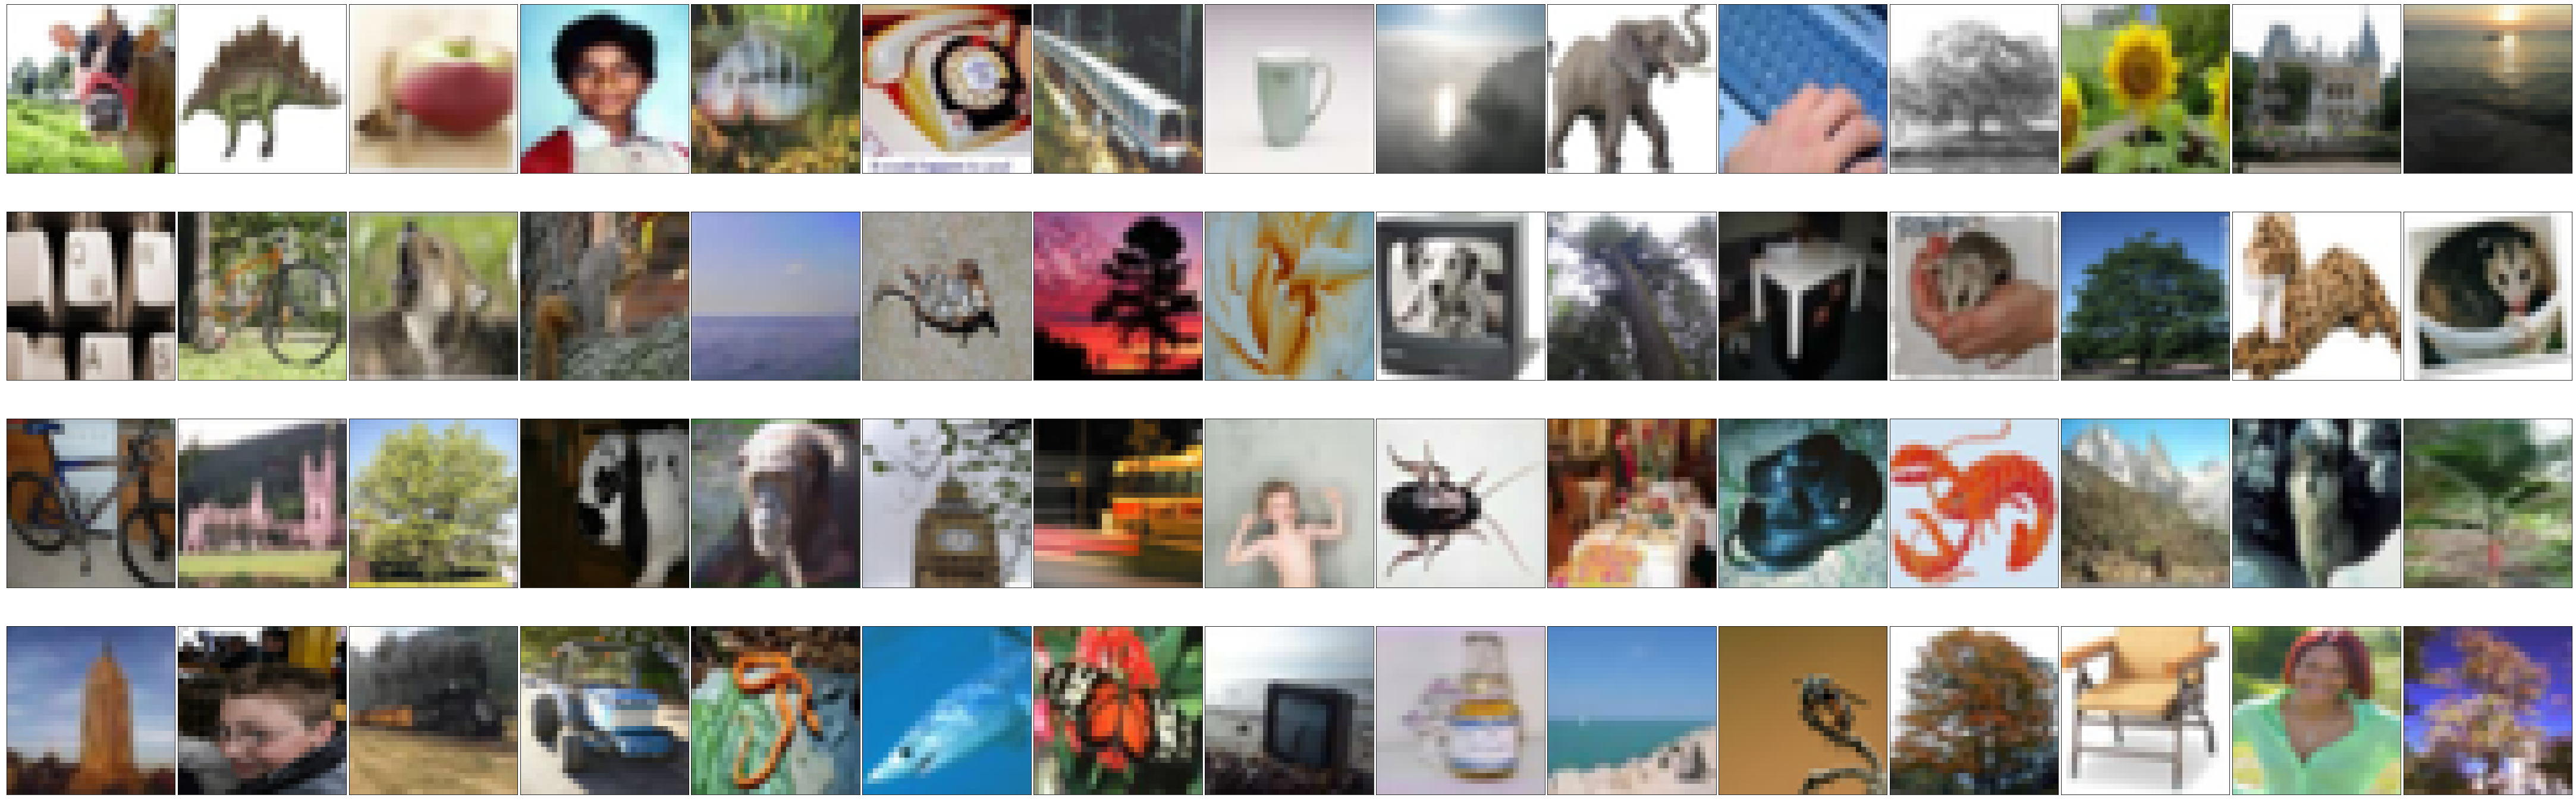

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=15, sharex=True, sharey=True, figsize=(60,20))
x_train = train_data.reshape((len(train_data), 3, 32, 32)).transpose(0, 2, 3, 1)

vis = x_train[0:60]

for image, row in zip([vis[:15], vis[15:30], vis[30:45], vis[45:60]], axes):
    for img, ax in zip(image, row):
        ax.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

# Step 3 - Pre-processing

In [8]:
#0-1 normalization  - pre-processing method 1
train_data = train_data/255
test_data = test_data/255

In [9]:
data = train_data.reshape(-1,32,32,3)
data_r = data[:,:,:,0]
data_g = data[:,:,:,1]
data_b = data[:,:,:,2]

In [10]:
#pre-processing method 2
mean = np.mean(data_r), np.mean(data_g), np.mean(data_b) #average
std = np.std(data_r), np.std(data_g), np.std(data_b) #Standard deviation

#Function conversion can fine-grained control of the image
#Image boundary information is lost, that is, the information on the corners and boundaries of some images is less useful. So padding is needed.
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding = 4), #Crop at a random position
    transforms.RandomVerticalFlip(p=0.5), #Flip the given PIL image horizontally randomly, with a probability of 0.5
    transforms.ToTensor(),  #convert a PIL image to tensor (H*W*C) in range [0,255] to a torch.Tensor(C*H*W) in the range [0,1]
    transforms.Normalize(mean, std)  #Normalized an tensor image with mean and standard deviation.                                    
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)                                     
])

In [11]:
trainset = torchvision.datasets.CIFAR100(root='./datasets/', train=True, download=True, transform=transform_train)  
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,shuffle=True, num_workers=4, drop_last=False)  
#this root path is the path that you store the downloading dataset from torchvision

testset = torchvision.datasets.CIFAR100(root='./datasets/', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,shuffle=True, num_workers=4, drop_last=False)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
trainset,testset

(Dataset CIFAR100
     Number of datapoints: 50000
     Root location: ./datasets/
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomCrop(size=(32, 32), padding=4)
                RandomVerticalFlip(p=0.5)
                ToTensor()
                Normalize(mean=(0.47818936940870016, 0.47818382758884653, 0.4781686789215679), std=(0.26819235699710614, 0.2681800159851806, 0.2682035859417288))
            ), Dataset CIFAR100
     Number of datapoints: 10000
     Root location: ./datasets/
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.47818936940870016, 0.47818382758884653, 0.4781686789215679), std=(0.26819235699710614, 0.2681800159851806, 0.2682035859417288))
            ))

# Step 4 - Build Model

In [13]:
num_classes=100

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [15]:
# Define a Convolutional Neural Network
# 13 convolutional layers and 3 fully connected layers
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64,affine=True),
            nn.ReLU(True),
            #output: 32 * 32 * 64
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64,affine=True),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #output: 16 * 16 * 64
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128,affine=True),
            nn.ReLU(True),
            #output: 16 * 16 * 128
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128,affine=True),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #output: 8 * 8 * 128
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256,affine=True),
            nn.ReLU(True),
            #output: 8 * 8 * 256
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256,affine=True),
            nn.ReLU(True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256,affine=True),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #output: 4 * 4 * 256
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512,affine=True),
            nn.ReLU(True),
            #output: 4 * 4 * 512
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512,affine=True),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512,affine=True),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #output: 2 * 2 * 512
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512,affine=True),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512,affine=True),
            nn.ReLU(True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512,affine=True),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 2048),
            nn.ReLU(inplace = True),
            nn.Dropout(),
            nn.Linear(2048, 2048),
            nn.ReLU(inplace = True),
            nn.Dropout(),
            nn.Linear(2048, num_classes),
        )
    def forward(self, x):
      output = self.features(x)
      output = output.view(output.size()[0],-1) #Convert the input value into a one-dimensional vector
      output = self.classifier(output)
      return output




In [16]:
net = Net().to(device)
print(net)

Net(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# Train Model - You don't have to run this part of codes

In [16]:
# define loss and optimizer

# using cross entropy as loss
criterion = nn.CrossEntropyLoss()  
# using SGD for parameter update
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-3)  
milestones=[15,30,45,60,75,90]
#epoch is multiplied by gamma when entering the range of milestones, and multiplied by gamma after leaving the range of milestones
train_schedular = optim.lr_scheduler.MultiStepLR(optimizer, milestones ,gamma=0.2)

In [17]:
# Train the network
def train(net, optimizer, epoch, num_epochs=10):
    Train_Loss_list = []
    net.train()
    if epoch > 0:
      train_schedular.step(epoch)
    train_loss = 0
    for i, data in enumerate(trainloader, 0):
        #running_loss = 0.0  
        # Calculate the current loss every batch_size times, and clear it later to calculate the loss of a new batch_size times
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad() 

        # forward + backward + optimize
        #print(inputs.shape)
        outputs = net(inputs)
        #print(outputs.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += criterion(outputs, labels).tolist()
        #running_loss += loss.item()

    train_loss /= len(testloader.dataset)
    print('Train set: Average loss: %.4f'%(train_loss))  
    #Train_Loss_list.append(train_loss)          
    return train_loss
    #print('Finished Training')


def test(net):
    predict = []
    Test_Loss_list = []
    net.eval()
    test_loss = 0
    correct = 0
    for i, data_test in enumerate(testloader, 0):
            images, test_labels = data_test
            images = images.to(device)
            test_labels = test_labels.to(device)
            net = net.cuda()
            outputs = net(images)
            test_loss += criterion(outputs, test_labels).tolist()
            
            _, predicted = torch.max(outputs.data, 1)
            #print(outputs.data),print('predicted'),print(predicted),print('labels'),print(test_labels)
            correct += predicted.eq(test_labels).sum()
            #predicted = predicted.tolist()
            #for i in range(len(predicted)):
              #predict.append(predicted[i])
    test_loss /= len(testloader.dataset)
    print('Test set: Average loss: %.4f'%(test_loss))
    correct = correct.tolist() #Get xxx in tensor(xxx, device='cuda:0')
    print(correct)
    accuracy = correct / len(testloader.dataset)
    print('Accuracy of the network on the 10000 test images: %.4f %%' % accuracy)
    
    return test_loss, accuracy, predict

In [18]:
time_start = time.time()

PATH = 'train_model.ipynb' #Storage path
Train_Loss_list = []
Test_Loss_list = []
Accuracy = []
for epoch in range(100): #train loop is 100
    print('epoch:%s'%epoch)
    Train_Loss_list.append(train(net, optimizer, epoch)) #get train loss
    torch.save(net, PATH)
    Test_Loss_list.append(test(net)[0]) #get test loss
    Accuracy.append(test(net)[1]) #get accuracy
torch.save(net, PATH) #store model

time_end=time.time()
print('time cost',time_end-time_start,'s')

epoch:0
Train set: Average loss: 0.0854
Test set: Average loss: 0.0168
388
Accuracy of the network on the 10000 test images: 0.0388 %
Test set: Average loss: 0.0167
388
Accuracy of the network on the 10000 test images: 0.0388 %
epoch:1


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train set: Average loss: 0.0795
Test set: Average loss: 0.0161
637
Accuracy of the network on the 10000 test images: 0.0637 %
Test set: Average loss: 0.0161
637
Accuracy of the network on the 10000 test images: 0.0637 %
epoch:2
Train set: Average loss: 0.0768
Test set: Average loss: 0.0164
550
Accuracy of the network on the 10000 test images: 0.0550 %
Test set: Average loss: 0.0164
550
Accuracy of the network on the 10000 test images: 0.0550 %
epoch:3
Train set: Average loss: 0.0740
Test set: Average loss: 0.0167
622
Accuracy of the network on the 10000 test images: 0.0622 %
Test set: Average loss: 0.0168
622
Accuracy of the network on the 10000 test images: 0.0622 %
epoch:4
Train set: Average loss: 0.0711
Test set: Average loss: 0.0151
890
Accuracy of the network on the 10000 test images: 0.0890 %
Test set: Average loss: 0.0150
890
Accuracy of the network on the 10000 test images: 0.0890 %
epoch:5
Train set: Average loss: 0.0691
Test set: Average loss: 0.0160
769
Accuracy of the netwo

In [19]:
print(Accuracy)

[0.0388, 0.0637, 0.055, 0.0622, 0.089, 0.0769, 0.0942, 0.1059, 0.0935, 0.1254, 0.1193, 0.1369, 0.1682, 0.1618, 0.1236, 0.3278, 0.3015, 0.3035, 0.3116, 0.3338, 0.2895, 0.2812, 0.3454, 0.3203, 0.3768, 0.3626, 0.3329, 0.3604, 0.3899, 0.404, 0.5278, 0.5364, 0.5427, 0.5352, 0.5497, 0.5395, 0.5513, 0.5502, 0.5311, 0.5394, 0.5373, 0.5374, 0.5474, 0.5351, 0.5526, 0.6097, 0.6095, 0.6117, 0.6084, 0.613, 0.6075, 0.6118, 0.6082, 0.6099, 0.6066, 0.6153, 0.6069, 0.6088, 0.6047, 0.6061, 0.6185, 0.617, 0.6203, 0.6193, 0.6198, 0.6223, 0.6169, 0.6199, 0.6227, 0.6215, 0.6225, 0.6208, 0.6221, 0.6217, 0.6247, 0.6224, 0.6229, 0.624, 0.6253, 0.6241, 0.6235, 0.6253, 0.6233, 0.6229, 0.6224, 0.6231, 0.6222, 0.6237, 0.6234, 0.6208, 0.6224, 0.6211, 0.6229, 0.623, 0.6231, 0.6241, 0.6234, 0.6232, 0.6252, 0.6215]


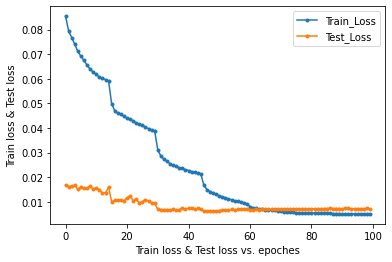

<Figure size 4320x4320 with 0 Axes>

In [20]:
epoch_range = range(100)
plt.plot(epoch_range, Train_Loss_list, '.-',label="Train_Loss")
plt.plot(epoch_range, Test_Loss_list, '.-',label="Test_Loss")
plt.xlabel('Train loss & Test loss vs. epoches')
plt.ylabel('Train loss & Test loss')
plt.legend(loc='best')
plt.figure(figsize = (60, 60))
plt.show()
#show the trend of train loss and test loss with epoch increasing

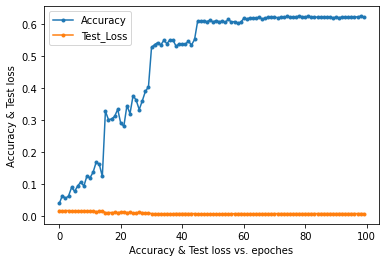

<Figure size 4320x4320 with 0 Axes>

In [21]:
epoch_range = range(100)
plt.plot(epoch_range, Accuracy, '.-',label="Accuracy")
plt.plot(epoch_range, Test_Loss_list, '.-',label="Test_Loss")
plt.xlabel('Accuracy & Test loss vs. epoches')
plt.ylabel('Accuracy & Test loss')
plt.legend(loc='best')
plt.figure(figsize = (60, 60))
plt.show()
#show the trend of test loss and accuracy with epoch increasing

# Test Model - You can just run codes of this part through train_model.ipynb (Pre-trained model)

### Get the test accuracy through the train model so you don't need to train the model

In [17]:
#net.eval()
test_loss = 0
correct = 0
PATH = 'train_model.ipynb' #train_model.ipynb need to be stored in "/content/gdrive/My Drive/Colab Notebooks/ass2" 
net = torch.load(PATH)
for i, data_test in enumerate(testloader, 0):
        images, test_labels = data_test
        images = images.to(device)
        test_labels = test_labels.to(device)
        net = net.cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        #print(predicted)
        #print('predicted'),print(predicted),print('labels'),print(labels.shape)
        correct += predicted.eq(test_labels).sum()
print(predicted)
#print(correct)
print('Accuracy of the network on the 10000 test images: %.4f %%' % (correct / len(testloader.dataset)))

tensor([17, 53, 37, 25, 81, 97, 34,  7, 64, 83, 69, 88, 91, 99, 56, 52],
       device='cuda:0')
Accuracy of the network on the 10000 test images: 0.6215 %


### Get confusion matrix

tensor([[80.,  0.,  1.,  ...,  0.,  0.,  0.],
        [ 0., 79.,  0.,  ...,  0.,  0.,  0.],
        [ 1.,  0., 56.,  ...,  0.,  4.,  1.],
        ...,
        [ 0.,  0.,  0.,  ..., 55.,  0.,  0.],
        [ 0.,  0.,  3.,  ...,  0., 37.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0., 69.]])


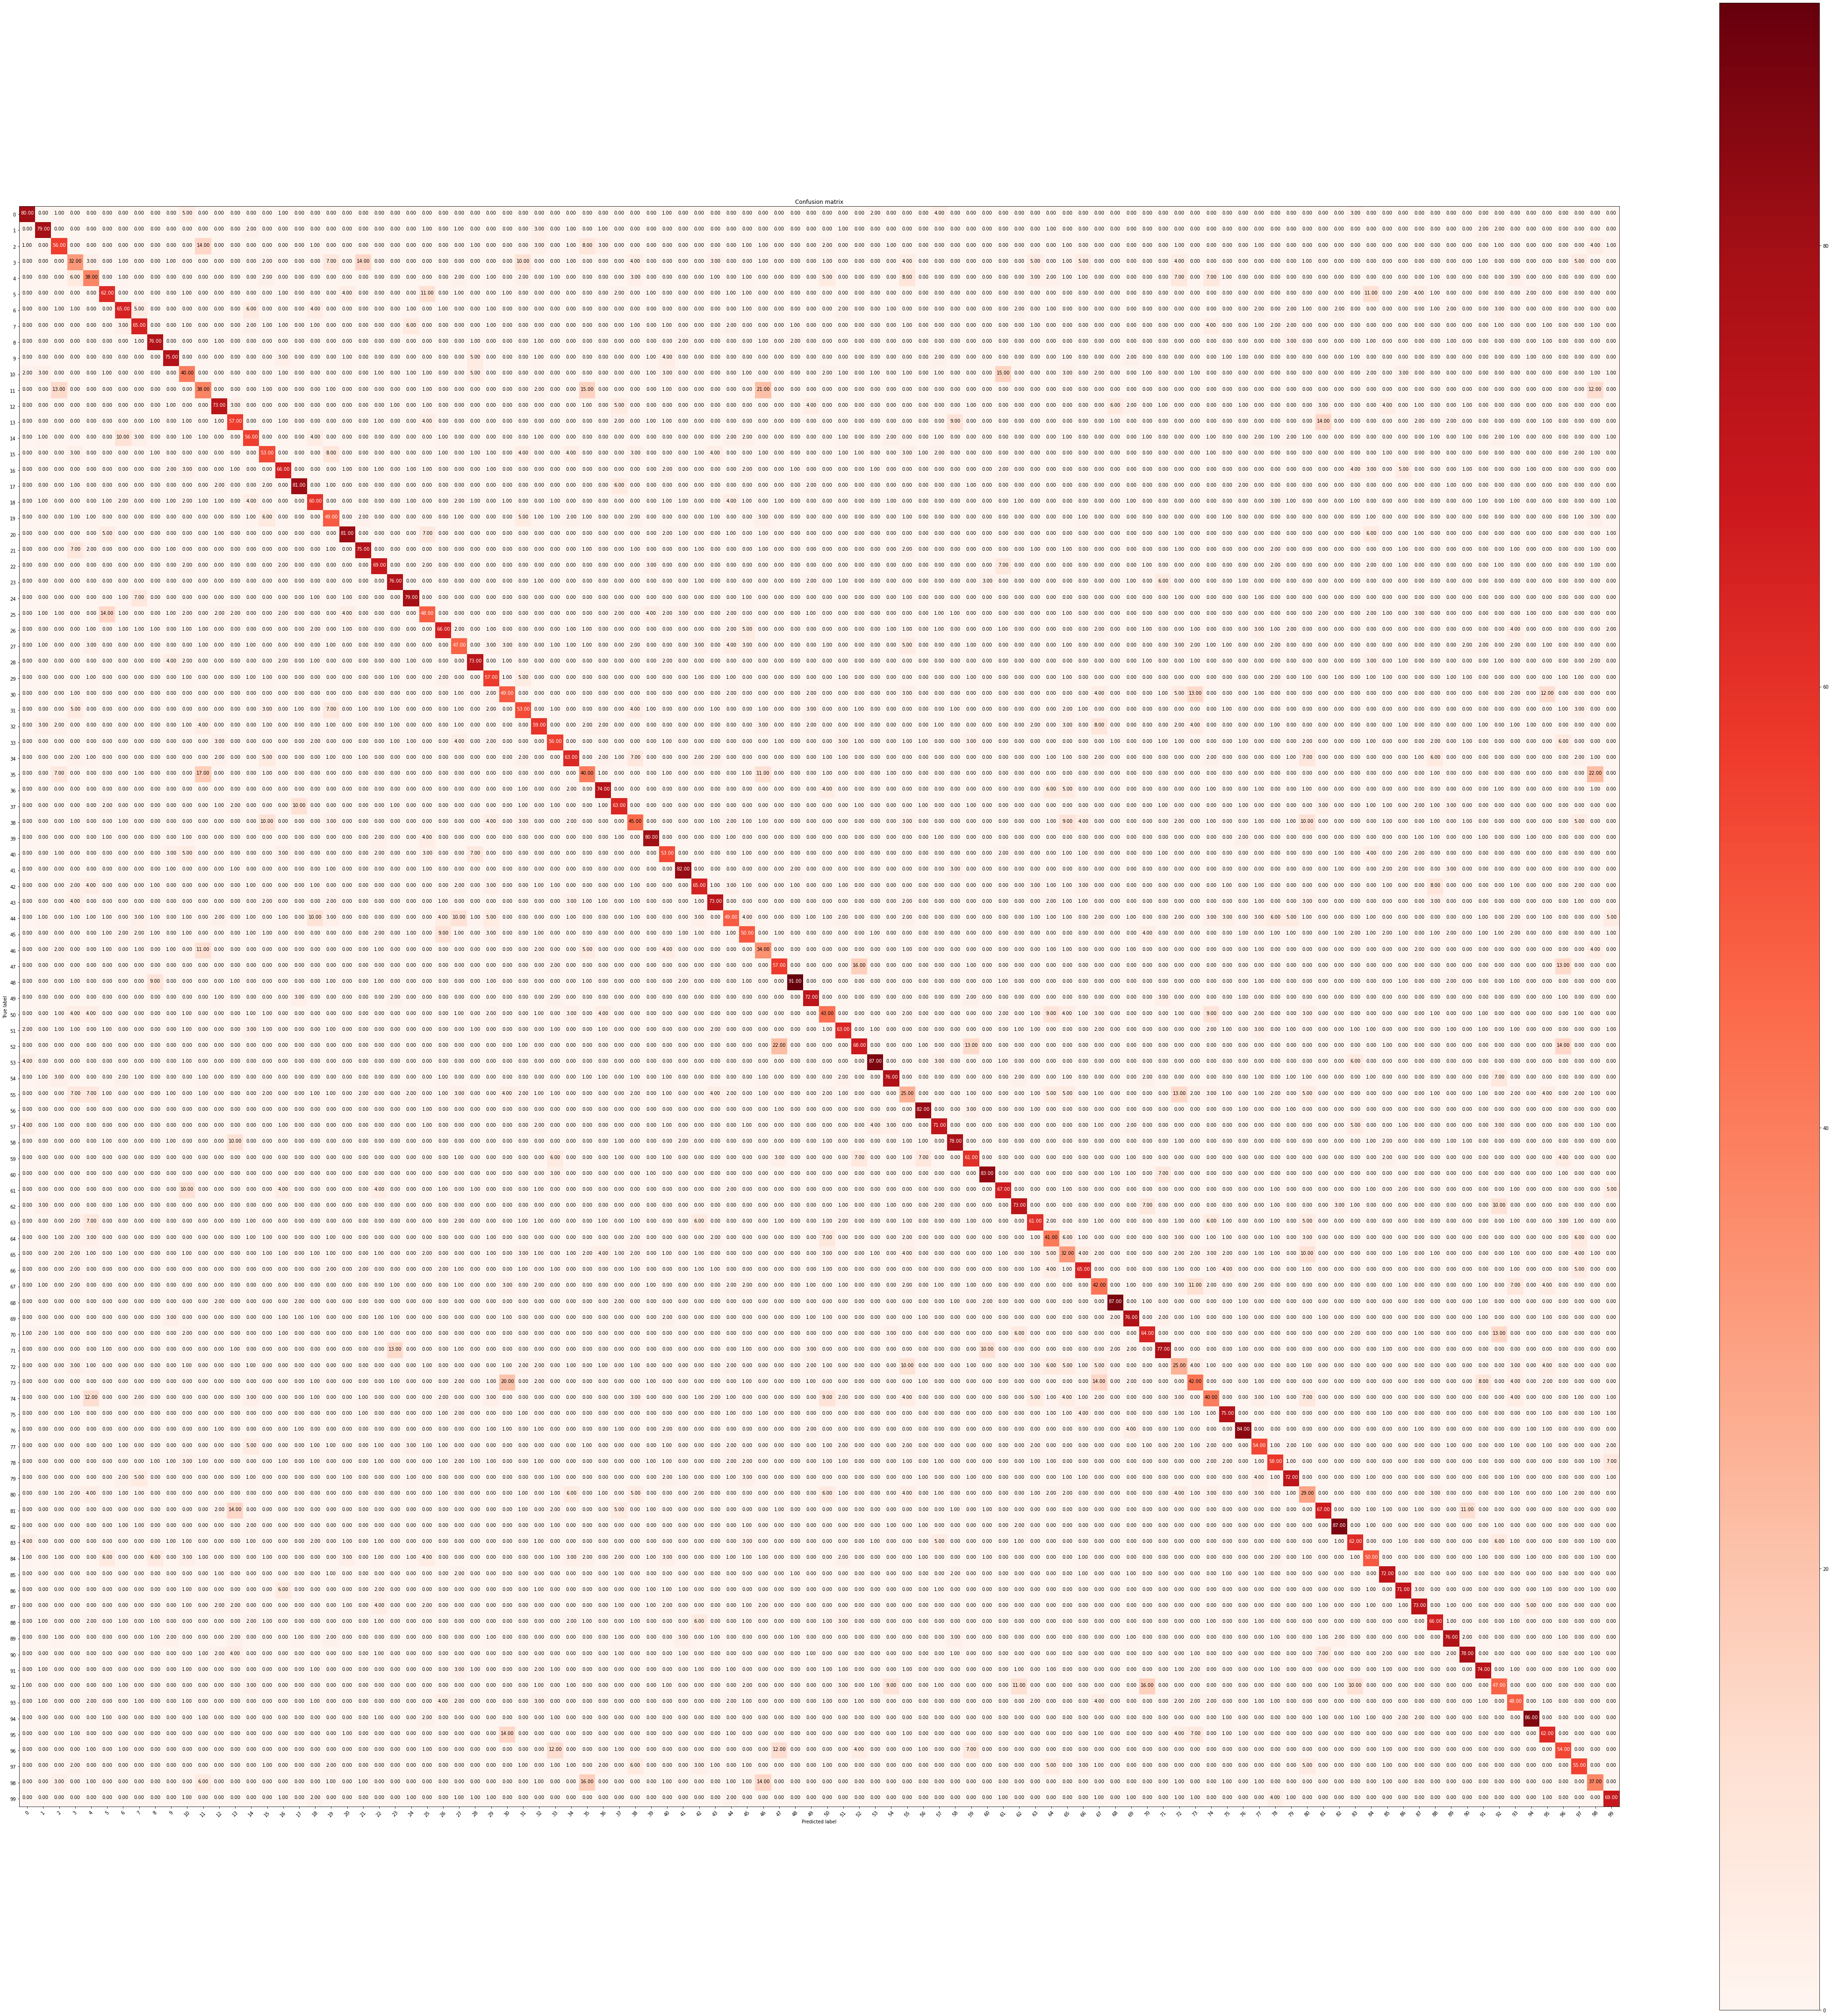

In [18]:
import itertools
def plot_confusion_matrix(cm):#Parameters are actual classification and predicted classification
    normalize=True
    plt.title('Confusion matrix')
    classes = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99]
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    color_format = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], color_format),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# 绘制混淆矩阵
def confusion_matrix(preds, labels, conf_matrix):
    preds = torch.argmax(preds, 1)
    for p, t in zip(preds, labels):
        conf_matrix[p, t] += 1
    return conf_matrix
conf_matrix = torch.zeros(100, 100)

for data, target in testloader:
    output = net(data.to(device))
    conf_matrix = confusion_matrix(output, target, conf_matrix)

print(conf_matrix)
np.set_printoptions(precision = 2)
plt.figure(figsize = (60, 60))
plot_confusion_matrix(conf_matrix)
plt.show()



### Get precision, recall and f1 score

In [19]:
#precision & recall 
preds = []
targs = []
for data, target in testloader:
    outputs = net(data.to(device))
    pred = torch.argmax(outputs, 1).cpu()
    pred = np.array(pred)
    for i in range(len(pred)):
        preds.append(pred[i])

    for i in range(len(target)):
        targs.append(target[i])

from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, size = precision_recall_fscore_support(targs, preds)
print('precision =',precision)
print('recall =',recall)
print('f1 =',f1)



precision = [0.82 0.84 0.55 0.3  0.39 0.58 0.62 0.65 0.84 0.76 0.42 0.36 0.67 0.58
 0.55 0.54 0.67 0.82 0.61 0.58 0.75 0.75 0.74 0.83 0.85 0.46 0.62 0.47
 0.77 0.67 0.5  0.56 0.55 0.58 0.54 0.38 0.76 0.64 0.39 0.82 0.58 0.83
 0.59 0.71 0.33 0.49 0.47 0.64 0.79 0.83 0.41 0.64 0.57 0.85 0.7  0.2
 0.91 0.7  0.76 0.64 0.86 0.66 0.71 0.55 0.47 0.28 0.66 0.44 0.88 0.77
 0.66 0.68 0.28 0.4  0.33 0.78 0.82 0.57 0.59 0.71 0.32 0.61 0.88 0.66
 0.48 0.86 0.78 0.72 0.7  0.74 0.76 0.76 0.43 0.57 0.86 0.66 0.57 0.6
 0.43 0.77]
recall = [0.8  0.79 0.56 0.32 0.38 0.62 0.65 0.65 0.76 0.75 0.4  0.38 0.73 0.57
 0.56 0.53 0.66 0.81 0.6  0.49 0.81 0.75 0.69 0.76 0.79 0.48 0.66 0.47
 0.73 0.57 0.49 0.53 0.59 0.56 0.63 0.4  0.74 0.63 0.45 0.8  0.53 0.82
 0.65 0.73 0.49 0.5  0.34 0.57 0.91 0.72 0.43 0.63 0.68 0.87 0.76 0.25
 0.82 0.71 0.78 0.61 0.83 0.67 0.73 0.61 0.41 0.32 0.65 0.42 0.87 0.76
 0.64 0.77 0.25 0.42 0.4  0.75 0.84 0.54 0.58 0.72 0.29 0.67 0.87 0.62
 0.5  0.72 0.71 0.73 0.66 0.76 0.78 0.74 0.47 

In [21]:
print('Model Classification Comparison:')
print('id '+'pre '+'recall '+'f1')
for i in range(100):
    print(i+1,round(precision[i],2),round(recall[i],2),round(f1[i],2))
    #precision, recall, f1 score of each class

from sklearn.metrics import precision_score,recall_score,f1_score
#Macro average refers to making each category have the same weight when calculating the mean, 
#and the final result is the arithmetic average of the indicators of each category.
print('precision:')
print(precision_score(targs, preds, average='macro')) 
print('recall:')
print(recall_score(targs, preds, average='macro'))
print('f1:')
print(f1_score(targs, preds, average='macro'))

Model Classification Comparison:
id pre recall f1
1 0.82 0.8 0.81
2 0.84 0.79 0.81
3 0.55 0.56 0.55
4 0.3 0.32 0.31
5 0.39 0.38 0.39
6 0.58 0.62 0.6
7 0.62 0.65 0.63
8 0.65 0.65 0.65
9 0.84 0.76 0.8
10 0.76 0.75 0.75
11 0.42 0.4 0.41
12 0.36 0.38 0.37
13 0.67 0.73 0.7
14 0.58 0.57 0.57
15 0.55 0.56 0.56
16 0.54 0.53 0.54
17 0.67 0.66 0.66
18 0.82 0.81 0.81
19 0.61 0.6 0.61
20 0.58 0.49 0.53
21 0.75 0.81 0.78
22 0.75 0.75 0.75
23 0.74 0.69 0.72
24 0.83 0.76 0.79
25 0.85 0.79 0.82
26 0.46 0.48 0.47
27 0.62 0.66 0.64
28 0.47 0.47 0.47
29 0.77 0.73 0.75
30 0.67 0.57 0.62
31 0.5 0.49 0.49
32 0.56 0.53 0.54
33 0.55 0.59 0.57
34 0.58 0.56 0.57
35 0.54 0.63 0.58
36 0.38 0.4 0.39
37 0.76 0.74 0.75
38 0.64 0.63 0.64
39 0.39 0.45 0.42
40 0.82 0.8 0.81
41 0.58 0.53 0.55
42 0.83 0.82 0.82
43 0.59 0.65 0.62
44 0.71 0.73 0.72
45 0.33 0.49 0.39
46 0.49 0.5 0.49
47 0.47 0.34 0.39
48 0.64 0.57 0.6
49 0.79 0.91 0.85
50 0.83 0.72 0.77
51 0.41 0.43 0.42
52 0.64 0.63 0.64
53 0.57 0.68 0.62
54 0.85 0.87 0.86